In [1]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import math
pdc = importr("pdc")
entropy = importr("entropy")
base = importr("base")
plt.style.use("ggplot")

In [2]:
# o l'altro.
df = pd.read_csv("./data_paper/CHLAMYDIA_Cases_2006-2014_20160707103149.csv", header = 2)
df.drop(columns = ["WEEK", "YEAR", "Unnamed: 61", "GUAM", "VIRGIN ISLANDS", "PAC TRUST TERR", "NORTHERN MARIANA ISLANDS", "AMERICAN SAMOA"], inplace = True)
df.replace("-", np.nan, inplace = True)
df = df.add_prefix("Chlamydia_")
df = df.astype("float64")
df.head()

,Chlamydia_ALABAMA,Chlamydia_ALASKA,Chlamydia_ARIZONA,Chlamydia_ARKANSAS,Chlamydia_CALIFORNIA,Chlamydia_COLORADO,Chlamydia_CONNECTICUT,Chlamydia_DELAWARE,Chlamydia_DISTRICT OF COLUMBIA,Chlamydia_FLORIDA,...,Chlamydia_TENNESSEE,Chlamydia_TEXAS,Chlamydia_UPSTATE NEW YORK,Chlamydia_UTAH,Chlamydia_VERMONT,Chlamydia_VIRGINIA,Chlamydia_WASHINGTON,Chlamydia_WEST VIRGINIA,Chlamydia_WISCONSIN,Chlamydia_WYOMING
0,NaN,7.0,334.0,NaN,553.0,NaN,NaN,78.0,NaN,415.0,...,NaN,NaN,23.0,15.0,NaN,NaN,NaN,59.0,17.0,28.0
1,NaN,5.0,NaN,190.0,684.0,35.0,10.0,72.0,NaN,437.0,...,428.0,NaN,93.0,38.0,10.0,NaN,293.0,122.0,44.0,3.0
2,NaN,18.0,279.0,122.0,1226.0,63.0,4.0,41.0,NaN,473.0,...,414.0,510.0,269.0,13.0,36.0,426.0,218.0,46.0,117.0,NaN
3,NaN,56.0,516.0,139.0,1233.0,124.0,9.0,74.0,NaN,609.0,...,599.0,744.0,342.0,38.0,29.0,715.0,485.0,67.0,81.0,24.0
4,381.0,63.0,327.0,177.0,1011.0,NaN,NaN,80.0,NaN,815.0,...,539.0,NaN,363.0,NaN,18.0,515.0,436.0,79.0,121.0,25.0


In [3]:
# Define the number of iteration you want to perform.
n_iter = 10
# The min lenght of the temporal window to generate the subsample time-series.
min_window_lenght = 10
# The max lenght of the temporal window to generate the subsample time-series.
max_window_lenght = 100

In [4]:
def rel_ent(x, m_min = 2, m_max = 6, t_min = 1, t_max = 3):
    # The Minimum Entropy Heuristic (MinE) automatically chooses an embedding dimension and tau with an optimal 
    # representational entropy as proxy for representational power.
    test = pdc.entropyHeuristic(x, m_min, m_max, t_min, t_max)
    # Conversion to a python dictionary.
    test = dict(zip(test.names, map(list, list(test))))
    ent = min(test["entropy.values"])
    
    ent_check = list()
    for t in range(len(x) - 9, len(x)):
        test_t = pdc.entropyHeuristic(x[0:t], m_min, m_max, t_min, t_max)
        test_t = dict(zip(test_t.names, map(list, list(test_t))))
        ent_t = min(test_t["entropy.values"])
        ent_check.append(ent_t)

    if not np.isfinite(np.mean(np.abs(np.diff(ent_check)))):
        ent = np.nan
        
    if np.isfinite(np.mean(np.abs(np.diff(ent_check)))):
        if np.mean(np.abs(np.diff(ent_check))) > 1e-2:
            ent = np.nan  
    
    m = test["m"]
    if len(m) == 0:
        m = np.nan
    else:
        m = m[0]
    
    tau = test["t"]
    if len(tau) == 0:
        tau = np.nan 
    else:
        tau = tau[0]
    
    return ent, m, tau

In [5]:
def sub_ts_PE(serie):
    # Get the index position of the first no-NaN values in the time-series.
    first_index = serie.first_valid_index()
    # Check if the time-series is composed only by NaN values.
    if first_index is None:
        return None
    # Get the index position of the last no-NaN values in the time-series.
    last_index = serie.last_valid_index()
    # Keep the serie between these two ranges of values.
    serie = serie.loc[first_index:last_index].reset_index(drop = True) 
    # Check if the time-series is smaller than 'min_window_lenght'.
    if len(serie) < min_window_lenght:
        return None

    # Define the random starting point in the time-series and its length to generate a subsample time-series.
    start = np.random.randint(len(serie) - min_window_lenght)
    length = np.random.randint(min_window_lenght, max_window_lenght + 1)

    # Check if take the sub time-series behind or above the starting point.
    if len(range(start + 1, len(serie))) < length:
        serie = serie.loc[start:len(serie)].reset_index(drop = True)
    else:
        serie = serie.loc[start:(start + length - 1)].reset_index(drop = True)
       
    n = serie.notna().sum()
    name = serie.name
    # Conversion of the python serie into a r vector of numeric class.
    serie = base.as_numeric(pandas2ri.py2ri(serie))

    # Search for the best m and tau parameters for this sub-time-series.
    ent, d, tau = rel_ent(x = serie, m_min = 2, m_max = 7, t_min = 1, t_max = 1)
    
    if not np.isfinite(d):
        return None

    ent_raw = np.array(entropy.entropy(pdc.codebook(serie, m = d, t = 1)))[0]/np.log(math.factorial(d))    

    return pd.Series([ent, ent_raw, n, d, tau], index = ["pdc_perm_entropy", "raw_perm_entropy", "n", "d", "tau"], 
                     name = name, dtype = "float64")

In [6]:
tqdm.pandas()
RESULTS = pd.concat([df.progress_apply(sub_ts_PE).transpose() for n in range(n_iter)], axis = 0, ignore_index = False)

C:\Users\Pietro\Anaconda3\envs\r\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
serie = base.as_numeric(pandas2ri.py2ri(pd.Series([np.nan, np.nan, np.nan])))
serie

nan,nan,nan


In [8]:
pdc.codebook(serie, m = 3, t = 1)

0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
RESULTS.dropna(how = "all", axis = 1, inplace = True) 

y = RESULTS["raw_perm_entropy"]
x = RESULTS["n"]

rm = y.isna().sum()

if rm > 0:
    y = y.dropna()
    x = x.dropna()

x_r = base.as_numeric(pandas2ri.py2ri(x))
y_r = base.as_numeric(pandas2ri.py2ri(y))
ent = y.groupby(by = x).apply(np.mean).values
ent_low = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.25)).values
ent_high = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.75)).values
n = y.groupby(by = x).apply(np.mean).index

results = pd.DataFrame({"Chi": 1 - ent, "n": n, "Chimin": 1 - ent_low, "Chimax": 1 - ent_high})

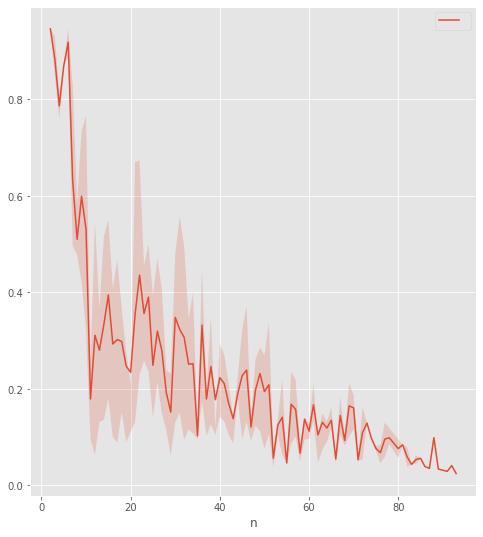

In [10]:
f = plt.figure(figsize = (8, 9))
results.plot(ax = f.gca(), x = "n", y = "Chi", label = "")
plt.fill_between(x = "n", y1 = "Chimin", y2 = "Chimax", data = results, alpha = 0.2)
plt.autoscale()